In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimDataset
from unsupervised_loss import UnsupervisedLoss


import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel
from math import sqrt
import scprep

from torch_geometric.data import Data

In [7]:
def train(train_loader, lamb):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        """
        Note that here I change the output of the model to incorporate the adj matrix (after the sigmoid transform)
        """
        # output, node_embed, adj = model(data)
        output = model(data)
        # adj = adj.numpy()
        # print(node_embed.shape)

        # eliminate self node
        # adj = adj - adj[0,0] * np.diag(np.ones(adj.shape[0]))
        # print(np.where(adj[0,:] != 0)[0])

        # train_nodes = np.arange(adj.shape[0])
        #  print(train_nodes[0])

        # unsupervised_loss = unsup_loss.UnsupervisedLoss(adj = adj, train_nodes=train_nodes, device = device)
        # nodes_batch = np.asarray(list(unsupervised_loss.extend_nodes(nodes=train_nodes, num_neg=6)))
        # loss_net = unsupervised_loss.get_loss_sage(node_embed, nodes_batch)

        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label)) # + lamb * loss_net
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        # pred,_,_ = model(data)
        pred = model(data)
        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [8]:
import importlib
import symsimDataset as symsim
importlib.reload(symsim)
dataset = symsim.SymsimDataset(root="data/")

In [9]:
dataset.num_features

300

In [10]:
# dataset = RnaVeloDataset(root='data/')
batch_size = 1

t = np.arange(1,10)
# dataset for training
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40) + list(t+50) + list(t+60) + list(t+70) + list(t+80) + list(t+90) + list(t+100) + list(t +110) + list(t+120) + list(t+130) + list(t+140)
#　train_mask = [3, 4, 5, 6]
# dataset for validation
val_mask = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

In [11]:
import importlib
import unsupervised_loss as unsup_loss
importlib.reload(unsup_loss)

<module 'unsupervised_loss' from '/Users/ziqizhang/Documents/research/GNN/gnn_traj_inference/unsupervised_loss.py'>

In [12]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)
# model = veloModel(dataset.num_features, device).to(device)
# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):

    train_loss = train(train_loader,lamb=1e-4)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=300, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2519, Train: 0.2283, Val: 0.2301
Epoch: 010, Loss: 0.0883, Train: 0.0854, Val: 0.1075
Epoch: 020, Loss: 0.0812, Train: 0.0782, Val: 0.1086
Epoch: 030, Loss: 0.0758, Train: 0.0732, Val: 0.1106
Epoch: 040, Loss: 0.0708, Train: 0.0678, Val: 0.1122
Epoch: 050, Loss: 0.0663, Train: 0.0634, Val: 0.1131
Epoch: 060, Loss: 0.0625, Train: 0.0598, Val: 0.1150
Epoch: 070, Loss: 0.0595, Train: 0.0571, Val: 0.1189
Epoch: 080, Loss: 0.0566, Train: 0.0542, Val: 0.1182
Epoch: 090, Loss: 0.0544, Train: 0.0523, Val: 0.1184
Epoch: 100, Loss: 0.0526, Train: 0.0507, Val: 0.1183


In [28]:
Path = "./trained_model/gnnSage_symsim.pt"
torch.save(model.state_dict(), Path)

In [29]:
Path = "./trained_model/gnnSage_symsim.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)
# model = GraphSAGEModel(dataset.num_features, device).to(device)
model = veloModel(dataset.num_features, device).to(device)
model.load_state_dict(torch.load(Path))
model.eval()

veloModel(
  (conv1): GraphConvolutionSage (300 -> 32)
  (conv2): GraphConvolutionSage (32 -> 8)
  (lin1): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
def pca_op(X, n_comps = 2, standardize  = True):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    if standardize:
        pipeline = Pipeline([('standardize', StandardScaler()), ('pca', PCA(n_components=n_comps))])
    else:
        pipeline = Pipeline([('pca', PCA(n_components=n_comps))])
    X_pca = pipeline.fit_transform(X)
    return X_pca

In [14]:
def umap_op(X, n_comps = 2):
    from umap import UMAP
    Umap = UMAP(n_components=n_comps)
    X_umap = Umap.fit_transform(X)
    return X_umap

In [15]:
def scatter(data, figsize = (15,5), method = 'pca'):
    # X should be something before pca
    if isinstance(data.x, torch.Tensor):
        X = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')
    if method == 'pca':
        X_pca = pca_op(X, n_comps = 2, standardize=False)
    elif method == 'umap':
        X_pca = umap_op(X, n_comps = 2)
    else:
        raise ValueError("either pca or umap")
    
    data = data.to(device)
    # pred,_,_ = model(data)
    pred = model(data)
    pred = pred.detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Prediction, RMSE="+str(rmse)[:5])
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

In [16]:
# for data in train_loader:
#     scatter(data)

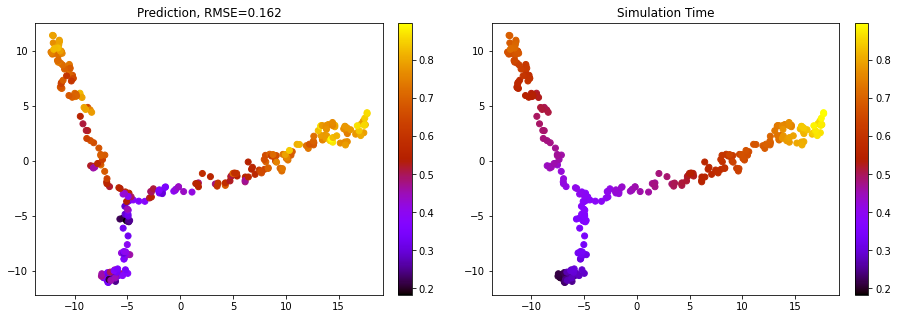

<Figure size 1080x360 with 0 Axes>

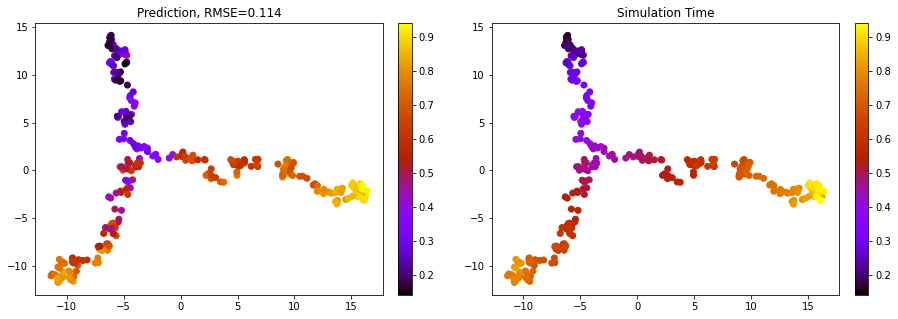

<Figure size 1080x360 with 0 Axes>

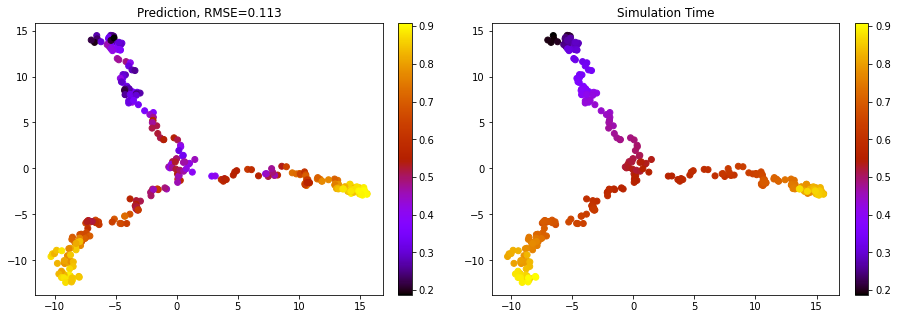

<Figure size 1080x360 with 0 Axes>

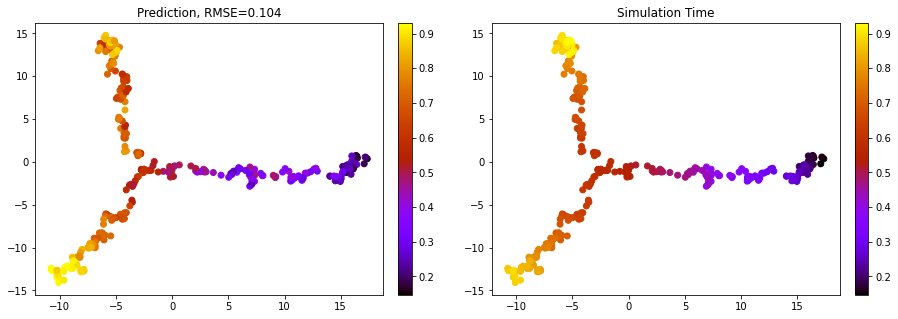

<Figure size 1080x360 with 0 Axes>

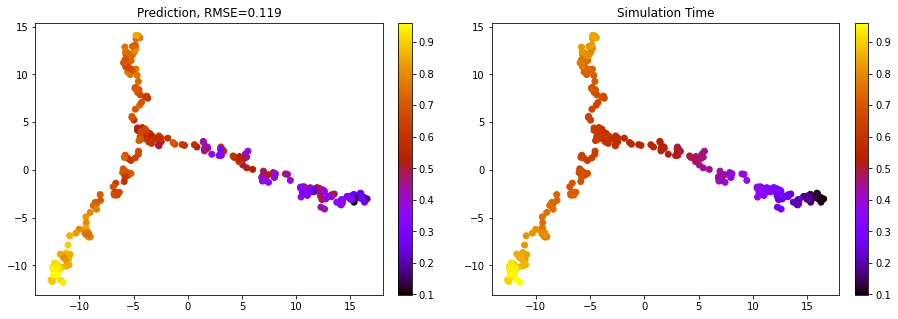

<Figure size 1080x360 with 0 Axes>

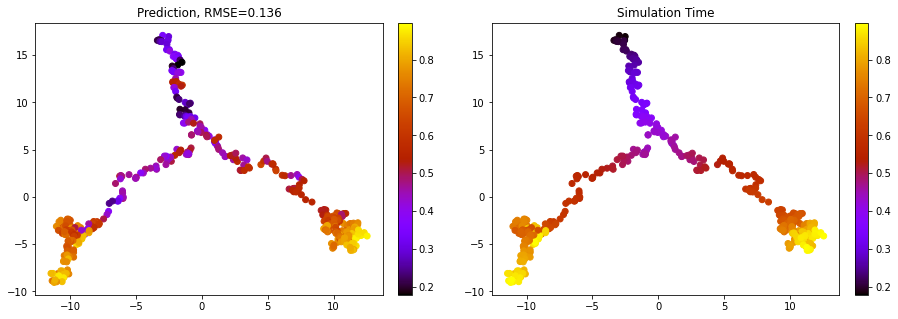

<Figure size 1080x360 with 0 Axes>

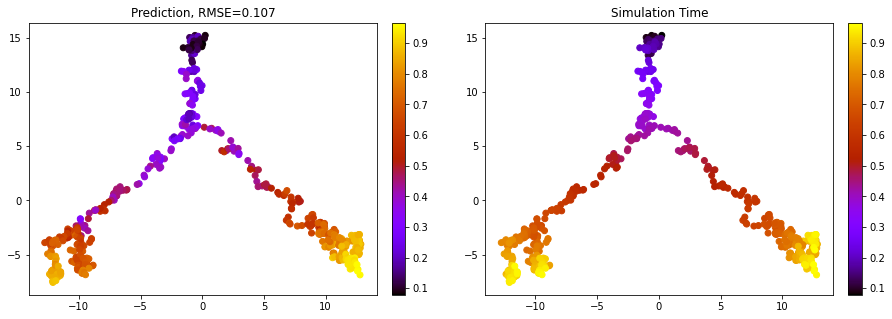

<Figure size 1080x360 with 0 Axes>

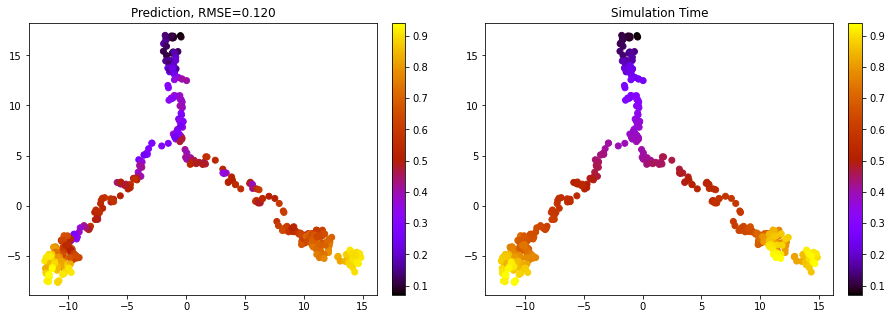

<Figure size 1080x360 with 0 Axes>

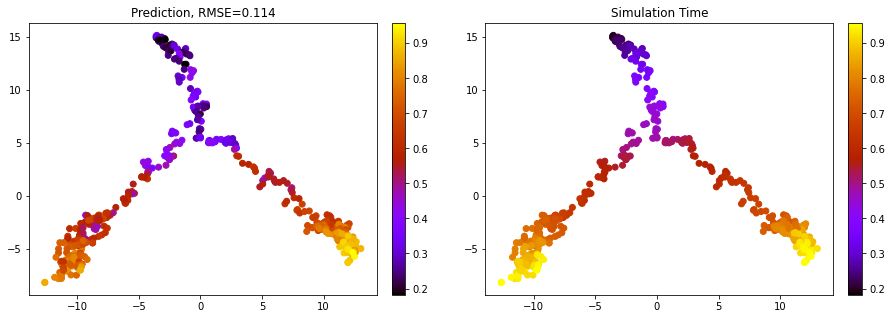

<Figure size 1080x360 with 0 Axes>

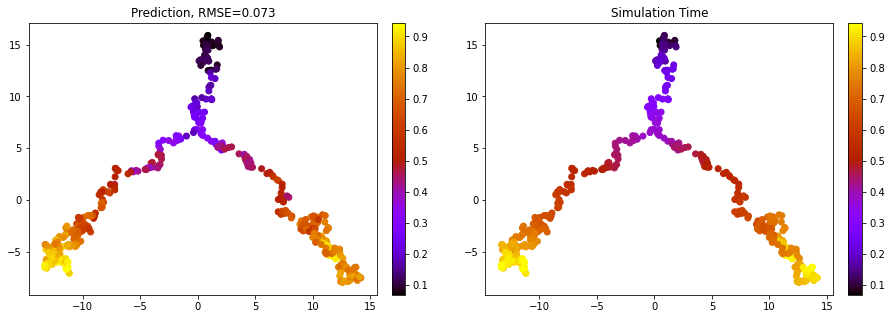

<Figure size 1080x360 with 0 Axes>

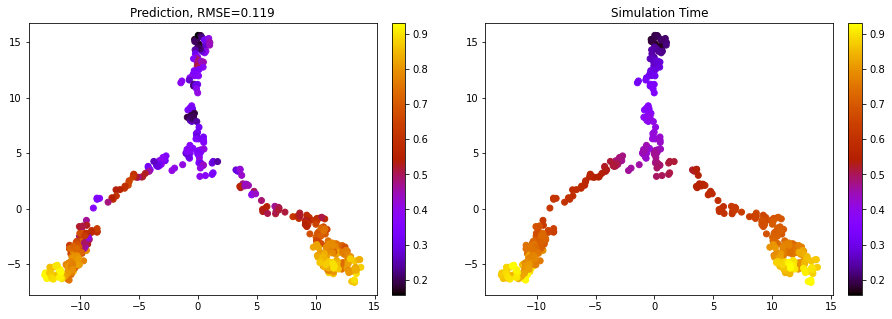

<Figure size 1080x360 with 0 Axes>

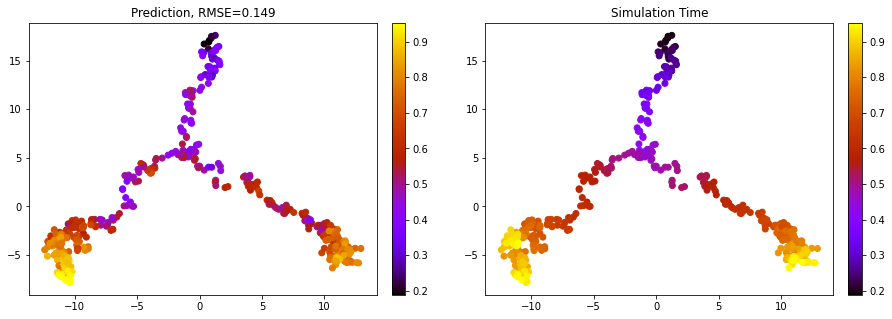

<Figure size 1080x360 with 0 Axes>

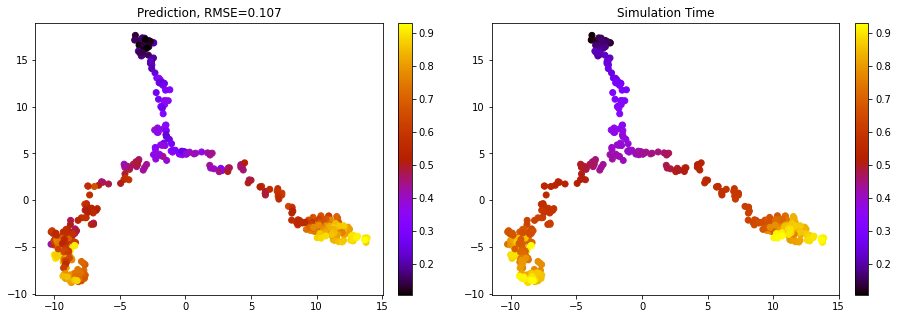

<Figure size 1080x360 with 0 Axes>

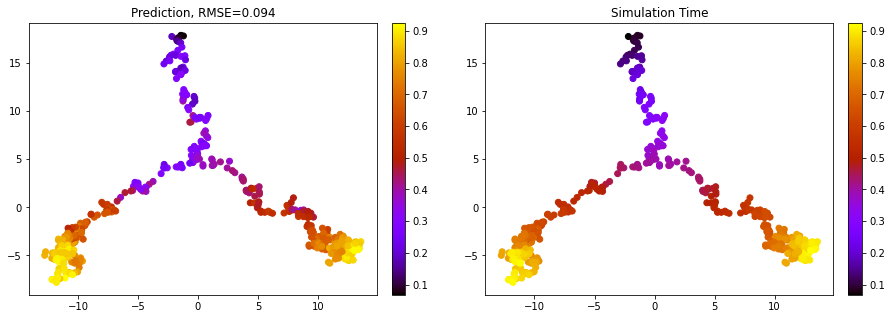

<Figure size 1080x360 with 0 Axes>

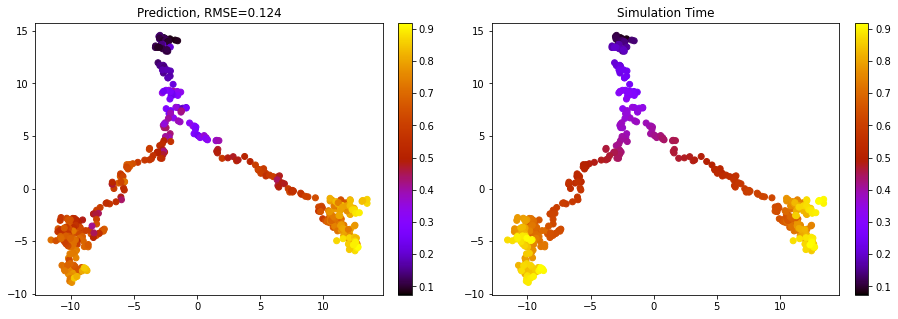

<Figure size 1080x360 with 0 Axes>

In [18]:
for data in val_loader:
    scatter(data)